# Step 1: Brief description of the problem and data
In this Kaggle competition project titled [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started), the task is to build a GAN (generative adversarial network) that generates 7,000 to 10,000 Monet-style images.

From Kaggle:
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos.
* The `monet` directories contain Monet paintings. Use these images to train your model.
* The `photo` directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Kaggle describes the files provided as follows:
* **monet_jpg** - 300 Monet paintings sized 256x256 in JPEG format
* **monet_tfrec** - 300 Monet paintings sized 256x256 in TFRecord format
* **photo_jpg** - 7028 photos sized 256x256 in JPEG format
* **photo_tfrec** - 7028 photos sized 256x256 in TFRecord format

The output of this project must be called `images.zip` and contain 7,000 to 10,000 images sized 256x256.

In [2]:
import os
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
from skimage import io, filters, color
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
from skimage.util import img_as_float
import numpy as np
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.preprocessing.image import load_img
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import zipfile
from sklearn.cluster import KMeans

# Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data
In this step, I will take a look at the data set, call out any areas of concern, and conclude by cleaning the data based on my findings.

The first thing I noticed in the general description of the data above is the data imbalance.  We have 300 Monet paintings and 7028 photos.

## Step 2 Part 1: View Samples and Confirm Dimensions
Next, I'll take a look at 5 examples of Monet paintings and 5 photos to get an idea of the data set, and confirm that the dimensions of all images are indeed 256x256 as stated in the Kaggle description.

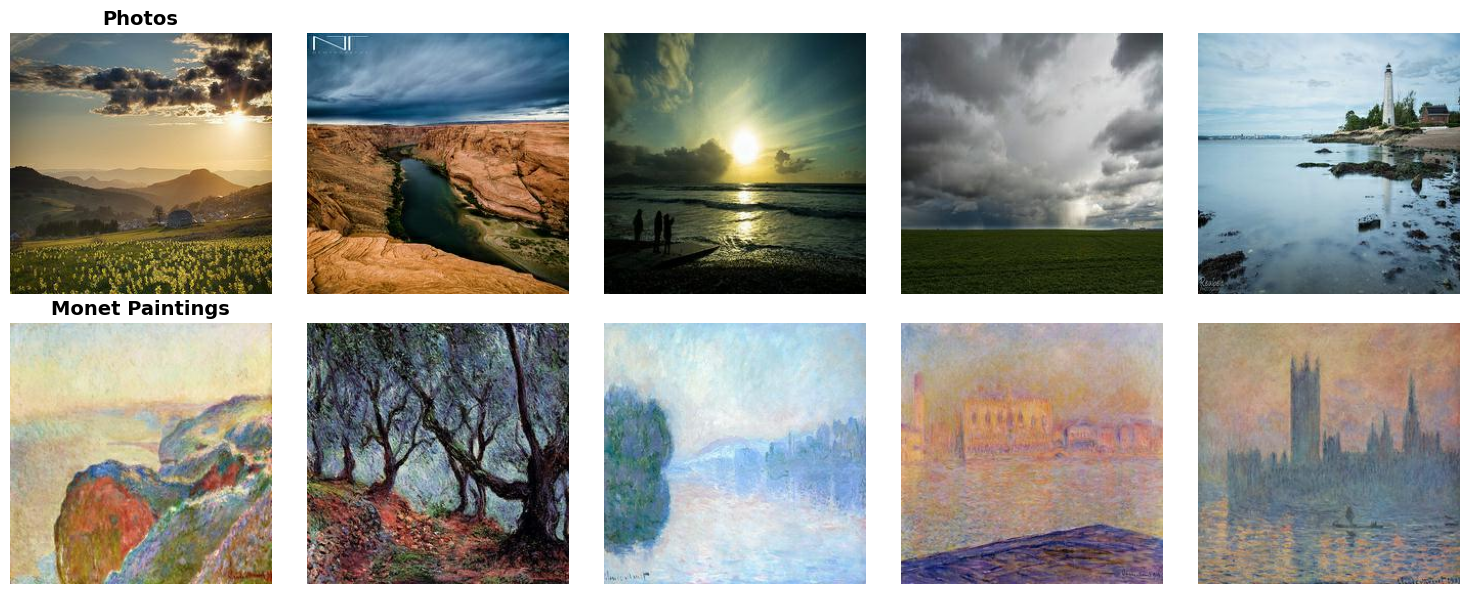

In [3]:
kaggle_photo_folder = "/kaggle/input/gan-getting-started/photo_jpg"
kaggle_monet_folder = "/kaggle/input/gan-getting-started/monet_jpg"

local_photo_folder = "photo_jpg"
local_monet_folder = "monet_jpg"

# Dynamically select the folder based on existence
photo_folder = kaggle_photo_folder if os.path.exists(kaggle_photo_folder) else local_photo_folder
monet_folder = kaggle_monet_folder if os.path.exists(kaggle_monet_folder) else local_monet_folder

def get_images(folder, num_images=5):
    files = os.listdir(folder)
    image_files = [os.path.join(folder, f) for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
    return image_files[:num_images]

photo_images = get_images(photo_folder)
monet_images = get_images(monet_folder)

def display_images(images, title, start_pos=1):
    for idx, img_path in enumerate(images, start=start_pos):
        img = Image.open(img_path)
        plt.subplot(2, 5, idx)  # Two rows, five images per row
        plt.imshow(img)
        plt.axis('off')
        if idx == start_pos:
            plt.title(title, fontsize=14, fontweight="bold")

plt.figure(figsize=(15, 6))
display_images(photo_images, "Photos", start_pos=1)
display_images(monet_images, "Monet Paintings", start_pos=6)
plt.tight_layout()
plt.show()

In [4]:
def get_image_dimensions_summary(subfolders):
    summary = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        dimensions_counter = Counter()

        if os.path.exists(folder_path):
            for root, _, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff', '.bmp', '.gif')):
                        try:
                            with Image.open(file_path) as img:
                                dimensions_counter[img.size] += 1
                        except Exception as e:
                            print(f"Could not process image {file_path}: {e}")

        summary[subfolder] = dimensions_counter

    return summary

subfolders_to_check = [monet_folder, photo_folder]

image_dimensions_summary = get_image_dimensions_summary(subfolders_to_check)
for subfolder, dimensions_count in image_dimensions_summary.items():
    print(f"Image dimensions summary in '{subfolder}':")
    for dimension, count in dimensions_count.items():
        print(f"  {dimension[0]}x{dimension[1]}: {count} image(s)")

Image dimensions summary in 'monet_jpg':
  256x256: 300 image(s)
Image dimensions summary in 'photo_jpg':
  256x256: 7038 image(s)


## Step 2 Part 2: Image Quality

Now that the count and dimensions of the provided images has been confirmed to match the info provided by Kaggle, we'll take a look at image quality.  I'll define image quality as blurriness, noise, and corruption.

To start, I'll compute the average noise for the images so that I can look for especially noisy images.

In [5]:
def compute_average_noise(subfolders):
    noise_stats = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        noise_values = []

        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                if not file.lower().endswith(".jpg"):
                    continue

                try:
                    image = io.imread(file_path)
                    if len(image.shape) == 3: # Convert to grayscale if needed
                        image = rgb2gray(image)
                    image = img_as_float(image)
                    stddev = np.std(image)
                    noise_values.append(stddev)

                except UnidentifiedImageError:
                    print(f"Could not process image: {file_path} (possibly corrupted)")
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        # Compute average noise (standard deviation) if there are noise values
        if noise_values:
            avg_noise = np.mean(noise_values)
            noise_stats[subfolder] = {
                "average_noise": avg_noise,
                "count": len(noise_values),
            }
        else:
            noise_stats[subfolder] = {
                "average_noise": None,
                "count": 0,
            }

    return noise_stats


subfolders_to_check = [monet_folder, photo_folder]
noise_statistics = compute_average_noise(subfolders_to_check)

for subfolder, stats in noise_statistics.items():
    print(f"Noise statistics for '{subfolder}':")
    print(f"  Image count: {stats['count']}")
    print(f"  Average noise (standard deviation): {stats['average_noise']:.6f}" if stats["average_noise"] else "  No valid images")

Noise statistics for 'monet_jpg':
  Image count: 300
  Average noise (standard deviation): 0.180934
Noise statistics for 'photo_jpg':
  Image count: 7038
  Average noise (standard deviation): 0.203307


In [6]:
def analyze_image_quality(subfolders, laplacian_var_min=0.002, noise_stddev_max=0.1):
    quality_issues = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        quality_issues[subfolder] = {"blurry": [], "corrupted": [], "noisy": []}
        total_images = 0

        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                if not file.lower().endswith(".jpg"):
                    continue
                total_images += 1

                try:
                    # Check if the image is corrupted
                    with Image.open(file_path) as img:
                        img.verify()
                except UnidentifiedImageError:
                    quality_issues[subfolder]["corrupted"].append(file_path)
                    continue

                try:
                    image = io.imread(file_path)
                    if len(image.shape) == 3:  # Convert RGB to grayscale if needed
                        image = rgb2gray(image)
                    image = img_as_float(image)
                except Exception as e:
                    quality_issues[subfolder]["corrupted"].append(file_path)
                    continue

                # Check for blurriness using variance of Laplacian
                laplacian_var = filters.laplace(image).var()
                if laplacian_var < laplacian_var_min:
                    quality_issues[subfolder]["blurry"].append(file_path)

                # Check for noise using mean and standard deviation
                stddev = np.std(image)
                if stddev > noise_stddev_max:
                    quality_issues[subfolder]["noisy"].append(file_path)

        # Calculate the percentage of each issue type
        if total_images > 0:
            blurry_percentage = (len(quality_issues[subfolder]["blurry"]) / total_images) * 100
            noisy_percentage = (len(quality_issues[subfolder]["noisy"]) / total_images) * 100
            corrupted_percentage = (len(quality_issues[subfolder]["corrupted"]) / total_images) * 100
        else:
            blurry_percentage = noisy_percentage = corrupted_percentage = 0

        quality_issues[subfolder]["blurry_percentage"] = blurry_percentage
        quality_issues[subfolder]["noisy_percentage"] = noisy_percentage
        quality_issues[subfolder]["corrupted_percentage"] = corrupted_percentage
        quality_issues[subfolder]["total_images"] = total_images

    return quality_issues


subfolders_to_check = [monet_folder, photo_folder]
quality_issues_summary = analyze_image_quality(subfolders_to_check, laplacian_var_min=0.002, noise_stddev_max=0.3)

for subfolder, issues in quality_issues_summary.items():
    print(f"Quality issues in '{subfolder}':")
    print(f"  Total images: {issues['total_images']}")
    print(f"  Blurry images: {len(issues['blurry'])} ({issues['blurry_percentage']:.2f}%)")
    print(f"  Noisy images: {len(issues['noisy'])} ({issues['noisy_percentage']:.2f}%)")
    print(f"  Corrupted images: {len(issues['corrupted'])} ({issues['corrupted_percentage']:.2f}%)")

    # Code to print list of blurry, noisy, or corrupted images if necessary
    # if issues["blurry"]:
    #     print("  List of blurry images:")
    #     for path in issues["blurry"]:
    #         print(f"    {path}")
    # if issues["noisy"]:
    #     print("  List of noisy images:")
    #     for path in issues["noisy"]:
    #         print(f"    {path}")
    # if issues["corrupted"]:
    #     print("  List of corrupted images:")
    #     for path in issues["corrupted"]:
    #         print(f"    {path}")


Quality issues in 'monet_jpg':
  Total images: 300
  Blurry images: 2 (0.67%)
  Noisy images: 3 (1.00%)
  Corrupted images: 0 (0.00%)
Quality issues in 'photo_jpg':
  Total images: 7038
  Blurry images: 155 (2.20%)
  Noisy images: 216 (3.07%)
  Corrupted images: 0 (0.00%)


## Step 2 Part 3: Color Space Distribution
I'll convert the images to different color spaces (RGB, HSV, and LAB), then compute the average and standard deviation of the channels in each of those color spaces.  I'll also plot a histogram of one image from each folder (monet and photo).

In [8]:
def extract_features(image_dir, model, target_size=(224, 224)):
    features = []
    image_paths = []

    for root, _, files in os.walk(image_dir):
        for file in files:
            if not file.lower().endswith(".jpg"):
                continue
            file_path = os.path.join(root, file)
            image_paths.append(file_path)

            try:
                # Load and preprocess the image
                img = load_img(file_path, target_size=target_size)
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)

                # Extract features using the pre-trained model
                feature = model.predict(img_array, verbose=0)
                features.append(feature.flatten())
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    features = np.array(features)
    return features, image_paths

def cluster_images(features, image_paths, n_clusters=5):
    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)

    # Organize images by cluster
    clustered_images = {i: [] for i in range(n_clusters)}
    for label, path in zip(labels, image_paths):
        clustered_images[label].append(path)

    return clustered_images

def display_cluster_examples(clustered_images, n_examples=5):
    for cluster_id, image_paths in clustered_images.items():
        print(f"\nCluster {cluster_id}:")
        plt.figure(figsize=(15, 5))
        for i, image_path in enumerate(image_paths[:n_examples]):
            img = Image.open(image_path)
            plt.subplot(1, n_examples, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"Image {i+1} {image_path[:5]}") # The first 5 characters of the path = "monet" or "photo"
        plt.show()

# Load pre-trained VGG16 model for feature extraction, which I downloaded from here https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
base_model = VGG16(weights='./models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, pooling="avg")

directories = [monet_folder, photo_folder]

all_features = []
all_image_paths = []

# Extract features from all images
for directory in directories:
    print(f"Processing directory: {directory}")
    features, image_paths = extract_features(directory, base_model)
    all_features.extend(features)
    all_image_paths.extend(image_paths)

all_features = np.array(all_features)
clustered_images = cluster_images(all_features, all_image_paths, n_clusters=5)
display_cluster_examples(clustered_images)

## Step 2 Part 4: Cluster Images Based on Features
Now I'll use the pre-trained model called **VGG16** to look for features in the images, and then use KMeans clustering to group together similar features.  I started by passing n=5 into the KMeans clustering algorithm, and observing whether the images that were clustered together make sense.

The output below will include 3 sections:
1. Clustering on just the `monet_jpg` paintings
2. Clustering on just the `photo_jpg` images
3. Clustering on both sets of images together

There are 3 interesting observations from the clusters shown above (when this was run locally):
1. The 5 clusters include Monet paintings **or** photos.  Interestingly there are no displayed clusters that include both Monet paintings and photos.  I've only displayed 5 images from each cluster, so this observation just suggests that the entire image set in each of the 5 clusters is exclusively Monet or exclusively photos.  It does not prove it.
2. Some clusters include images that don't visually seem to be related.  For example, the 5 example images from cluster 0 show 4 images with trees and 1 image that seems unrelated with no obvious trees.  The 5 images shown in cluster 1 include 4 images of boats in a harbor and 1 image that appears to show red flowers dotted amongst some greenery.
3. 1 cluster doesn't appear to have an obvious theme.  The 5 images displayed in cluster 4 include 1 image of houses along a dirt road, 1 image of boats along the shore, 1 image of a grassy hillside with rocks, and 2 images of seaside cliffs.

Color space analysis for 'photo_jpg':
  Total images: 7038
  RGB mean: [102.96808675 104.1944681   97.92882523]
  RGB std: [56.58028379 51.70053556 56.0432916 ]
  HSV mean: [0.3470734  0.39772614 0.47955227]
  HSV std: [0.19682639 0.22700811 0.22478036]
  LAB mean: [43.12801966  0.67542049  3.7163903 ]
  LAB std: [21.10943131  6.10424943 14.30241152]



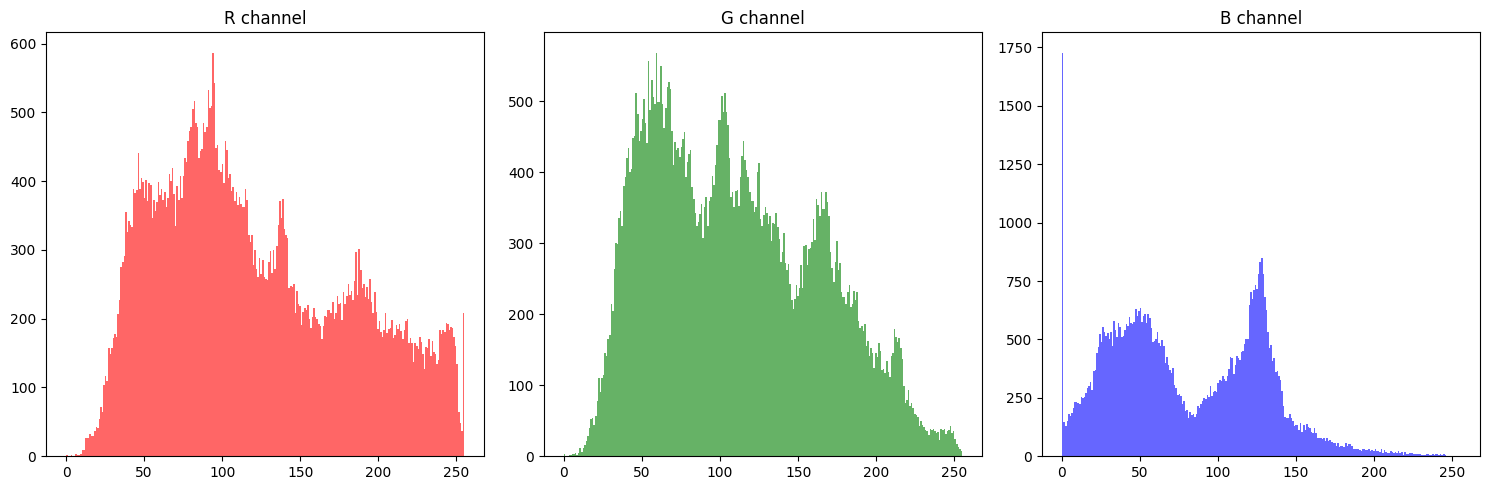

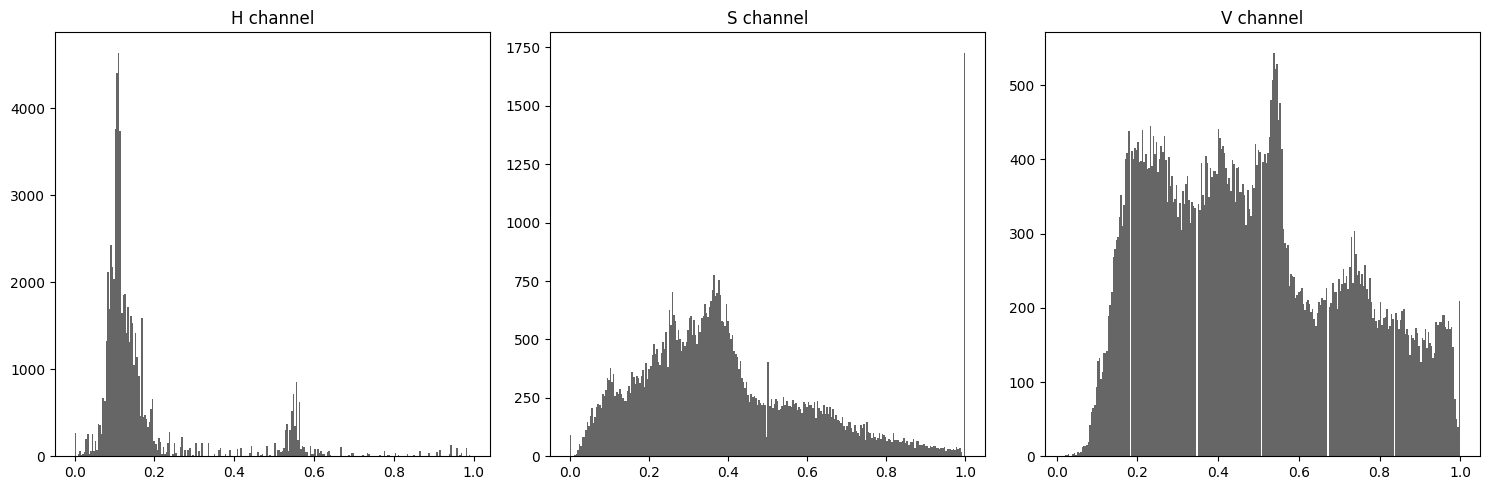

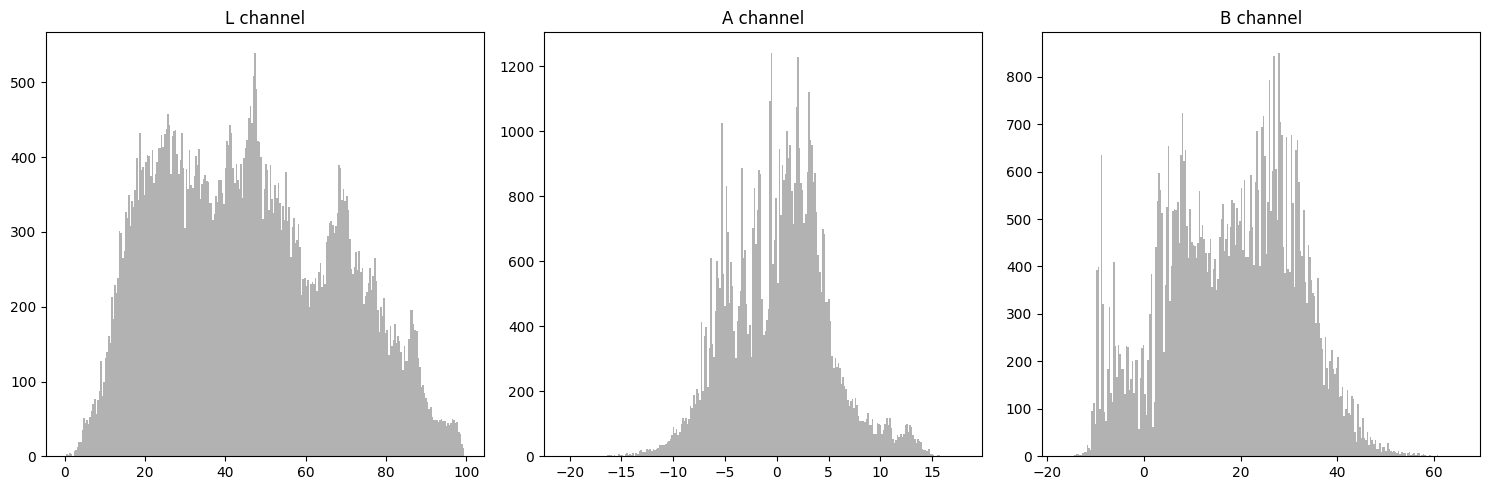

In [7]:
def color_space_analysis(subfolders):
    analysis_results = {}

    for subfolder in subfolders:
        folder_path = os.path.join(subfolder)
        analysis_results[subfolder] = {"rgb": [], "hsv": [], "lab": []}

        total_images = 0
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                if not file.lower().endswith((".jpg")):
                    continue
                total_images += 1

                try:
                    image = io.imread(file_path)

                    # Convert to RGB if the image is in another format
                    if len(image.shape) == 2:  # Grayscale image
                        image = color.gray2rgb(image)
                    elif len(image.shape) == 3 and image.shape[2] == 4:  # RGBA image
                        image = image[:, :, :3]

                    # Convert the image to different color spaces
                    hsv_image = rgb2hsv(image)
                    lab_image = rgb2lab(image)

                    # Calculate statistics for RGB, HSV, and LAB
                    rgb_mean = np.mean(image, axis=(0, 1))
                    rgb_std = np.std(image, axis=(0, 1))
                    hsv_mean = np.mean(hsv_image, axis=(0, 1))
                    hsv_std = np.std(hsv_image, axis=(0, 1))
                    lab_mean = np.mean(lab_image, axis=(0, 1))
                    lab_std = np.std(lab_image, axis=(0, 1))

                    analysis_results[subfolder]["rgb"].append((rgb_mean, rgb_std))
                    analysis_results[subfolder]["hsv"].append((hsv_mean, hsv_std))
                    analysis_results[subfolder]["lab"].append((lab_mean, lab_std))

                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

        def compute_average_and_std(channel_data):
            if channel_data:
                avg_mean = np.mean([item[0] for item in channel_data], axis=0)
                avg_std = np.mean([item[1] for item in channel_data], axis=0)
                return avg_mean, avg_std
            return None, None

        # Store color statistics for each color space
        rgb_avg_mean, rgb_avg_std = compute_average_and_std(analysis_results[subfolder]["rgb"])
        hsv_avg_mean, hsv_avg_std = compute_average_and_std(analysis_results[subfolder]["hsv"])
        lab_avg_mean, lab_avg_std = compute_average_and_std(analysis_results[subfolder]["lab"])

        analysis_results[subfolder]["rgb_avg_mean"] = rgb_avg_mean
        analysis_results[subfolder]["rgb_avg_std"] = rgb_avg_std
        analysis_results[subfolder]["hsv_avg_mean"] = hsv_avg_mean
        analysis_results[subfolder]["hsv_avg_std"] = hsv_avg_std
        analysis_results[subfolder]["lab_avg_mean"] = lab_avg_mean
        analysis_results[subfolder]["lab_avg_std"] = lab_avg_std
        analysis_results[subfolder]["total_images"] = total_images

    return analysis_results

def plot_histograms(image, color_space):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    if color_space == 'rgb':
        color_channels = ['r', 'g', 'b']
        for i, channel in enumerate(color_channels):
            axes[i].hist(image[:, :, i].ravel(), bins=256, color=channel, alpha=0.6)
            axes[i].set_title(f'{channel.upper()} channel')
    elif color_space == 'hsv':
        color_channels = ['h', 's', 'v']
        hsv_image = rgb2hsv(image)
        for i, channel in enumerate(color_channels):
            axes[i].hist(hsv_image[:, :, i].ravel(), bins=256, color=mcolors.CSS4_COLORS.get(channel, 'black'), alpha=0.6)
            axes[i].set_title(f'{channel.upper()} channel')
    elif color_space == 'lab':
        color_channels = ['l', 'a', 'b']
        lab_image = rgb2lab(image)
        for i, channel in enumerate(color_channels):
            axes[i].hist(lab_image[:, :, i].ravel(), bins=256, color='gray', alpha=0.6)
            axes[i].set_title(f'{channel.upper()} channel')

    plt.tight_layout()
    plt.show()

subfolders_to_check = [monet_folder, photo_folder]
color_analysis_results = color_space_analysis(subfolders_to_check)

for subfolder, results in color_analysis_results.items():
    print(f"Color space analysis for '{subfolder}':")
    print(f"  Total images: {results['total_images']}")
    print(f"  RGB mean: {results['rgb_avg_mean']}")
    print(f"  RGB std: {results['rgb_avg_std']}")
    print(f"  HSV mean: {results['hsv_avg_mean']}")
    print(f"  HSV std: {results['hsv_avg_std']}")
    print(f"  LAB mean: {results['lab_avg_mean']}")
    print(f"  LAB std: {results['lab_avg_std']}")
    print()

    # Plot histograms for the first image in the folder
    folder_path = os.path.join(subfolder)
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            if not file.lower().endswith((".jpg")):
                continue

            try:
                image = io.imread(file_path)
                # Show histograms for RGB, HSV, and LAB color spaces
                plot_histograms(image, 'rgb')
                plot_histograms(image, 'hsv')
                plot_histograms(image, 'lab')
                break  # Show histograms only for the first valid image
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

# Step 3: Model Architecture
The code below trains a GAN (generative adversarial network), which is the suggested architecture for this solution in both Coursera and Kaggle.  The following 3-step process describes how it will work.
1. The generator network learns to produce images that mimic Monet's style.
2. The discriminator network evaluates how "Monet-like" the generated images are by distinguishing between real Monet images and generated ones.
3. This adversarial process pushes the generator to create increasingly realistic Monet-style images.

GANs don't require explicit pixel-to-pixel correspondence between Monet's images and other datasets. Instead, they learn the artistic features from a collection of Monet’s works.

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [3]:
# Use GPU if available to speed up training
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps") # For using GPU on Apple Silicon
else:
    device = torch.device("cpu")
print (device)

cpu


In [44]:
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

def create_loaders(photo_batch_size=16, monet_batch_size=4):
    data_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    photo_files = [os.path.join(photo_folder, file) for file in os.listdir(photo_folder)]
    monet_files = [os.path.join(monet_folder, file) for file in os.listdir(monet_folder)]

    class FlatImageDataset(Dataset):
        def __init__(self, file_paths, transform=None):
            self.file_paths = file_paths
            self.transform = transform

        def __len__(self):
            return len(self.file_paths)

        def __getitem__(self, idx):
            img_path = self.file_paths[idx]
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img

    photo_dataset = FlatImageDataset(photo_files, transform=data_transforms)
    monet_dataset = FlatImageDataset(monet_files, transform=data_transforms)

    photo_loader = DataLoader(photo_dataset, batch_size=photo_batch_size, shuffle=True)
    monet_loader = DataLoader(monet_dataset, batch_size=monet_batch_size, shuffle=True)

    return photo_loader, monet_loader

photo_loader, monet_loader = create_loaders()

In [38]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train the generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Train the discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

Epoch [1/10], Batch [0], G_Loss: 2.733491897583008, D_Loss: 0.6988973021507263
Epoch [1/10], Batch [10], G_Loss: 1.2861685752868652, D_Loss: 0.2956787347793579
Epoch [1/10], Batch [20], G_Loss: 1.1238648891448975, D_Loss: 0.29125046730041504
Epoch [1/10], Batch [30], G_Loss: 0.9241309762001038, D_Loss: 0.3285542130470276
Epoch [1/10], Batch [40], G_Loss: 0.9513090252876282, D_Loss: 0.28964442014694214
Epoch [1/10], Batch [50], G_Loss: 0.7955808639526367, D_Loss: 0.23475281894207
Epoch [1/10], Batch [60], G_Loss: 0.7269705533981323, D_Loss: 0.2559521198272705
Epoch [1/10], Batch [70], G_Loss: 0.758899450302124, D_Loss: 0.26417139172554016
Epoch [2/10], Batch [0], G_Loss: 0.7535527348518372, D_Loss: 0.2747395634651184
Epoch [2/10], Batch [10], G_Loss: 0.7358235120773315, D_Loss: 0.22467654943466187
Epoch [2/10], Batch [20], G_Loss: 0.7197773456573486, D_Loss: 0.26792895793914795
Epoch [2/10], Batch [30], G_Loss: 0.7206982970237732, D_Loss: 0.2578258514404297
Epoch [2/10], Batch [40], G_L

In [40]:
def generate_images_and_store_to_zip(suffix):
    # Save generated images in a zip file
    output_dir = "generated_images_" + suffix
    os.makedirs(output_dir, exist_ok=True)
    num_images_to_generate = 8000

    with zipfile.ZipFile("images_" + suffix + ".zip", "w") as zipf:
        image_counter = 1  # Initialize a counter to generate unique file names
        for i, photo_batch in enumerate(photo_loader):
            real_photos = photo_batch.to(device)
            fake_monets = generator(real_photos)
            fake_monets = (fake_monets * 0.5 + 0.5).clamp(0, 1)  # Denormalize to [0, 1]

            for j, img in enumerate(fake_monets):
                img = transforms.ToPILImage()(img.cpu())
                img_path = os.path.join(output_dir, f"image_{image_counter}.jpg")
                img.save(img_path)
                zipf.write(img_path, os.path.basename(img_path))
                image_counter += 1

                if image_counter > num_images_to_generate:
                    break
            if image_counter > num_images_to_generate:
                break

# While Kaggle requires the output to be named "images.zip", I will append a suffix to
# each iteration here in my Jupyter notebook to keep track of the output.  I will then
# submit each of these outputs to Kaggle to get a score.
generate_images_and_store_to_zip(suffix="baseline")

In [7]:
# Kaggle provided the following score for this model
scores = [119.85307]
labels = ["Baseline"]

# Step 4: Results and Analysis
Now that a baseline model has been developed and a score has been obtained from Kaggle, the code below implements a few different models in an attempt to improve the score.
1. Learning rate schedulers
2. Learning rate schedulers + increase batch sizes
3. Learning rate schedulers + label smoothing
4. Learning rate schedulers with 20 epochs

## Step 4 Part 1: Add learning rate schedulers
Let's start by adding learning rate schedulers.  The code below is mostly identical to the previous code used.  Two new snippets of code were added, along with comments saying "NEW CODE" to help you find them below.

In [42]:
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# NEW CODE Learning rate schedulers
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.5)

photo_loader, monet_loader = create_loaders()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train the generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Train the discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

    # NEW CODE Step the learning rate schedulers
    scheduler_G.step()
    scheduler_D.step()

Epoch [1/10], Batch [0], G_Loss: 2.9811463356018066, D_Loss: 1.0329653024673462
Epoch [1/10], Batch [10], G_Loss: 1.3993165493011475, D_Loss: 0.3160982131958008
Epoch [1/10], Batch [20], G_Loss: 1.1740236282348633, D_Loss: 0.25731825828552246
Epoch [1/10], Batch [30], G_Loss: 1.128981351852417, D_Loss: 0.27746492624282837
Epoch [1/10], Batch [40], G_Loss: 0.8868467807769775, D_Loss: 0.2779805064201355
Epoch [1/10], Batch [50], G_Loss: 0.871246874332428, D_Loss: 0.27996984124183655
Epoch [1/10], Batch [60], G_Loss: 0.8693566918373108, D_Loss: 0.23059909045696259
Epoch [1/10], Batch [70], G_Loss: 0.7943083643913269, D_Loss: 0.23978528380393982
Epoch [2/10], Batch [0], G_Loss: 0.8119150400161743, D_Loss: 0.2955681085586548
Epoch [2/10], Batch [10], G_Loss: 0.7404530644416809, D_Loss: 0.26478099822998047
Epoch [2/10], Batch [20], G_Loss: 0.7455764412879944, D_Loss: 0.25951212644577026
Epoch [2/10], Batch [30], G_Loss: 0.8018768429756165, D_Loss: 0.2680921256542206
Epoch [2/10], Batch [40],

In [43]:
generate_images_and_store_to_zip(suffix="lr_sched")

In [8]:
# Kaggle provided the following score for this model, which is slightly better than the baseline model
scores.append(113.79571)
labels.append("LR Sched")

---
## Step 4 Part 2: Add learning rate schedulers and increase batch sizes
Since the learning rate schedulers slightly improved the score, the code below keeps the learning rate schedulers and further tweaks the model to increase batch sizes.

Increasing batch sizes could help improve the model by improving training stability and convergence for several reasons.
1. Better Gradient Estimation: Larger batch sizes reduce the variance in gradient estimates. This can lead to more stable updates for both the generator and the discriminator, which is particularly important in GANs where the two networks compete in a delicate equilibrium.
2. Smoother Loss Landscape: A larger batch size results in more consistent gradients, which can help the optimizer navigate the loss landscape more smoothly. This can prevent the model from oscillating or diverging during training.
3. Improved Sample Diversity: With a larger batch size, the model sees a more diverse set of examples in each update. This helps both the generator and discriminator learn more robust representations, reducing mode collapse in the generator.
4. Batch Normalization Effectiveness: If using batch normalization, larger batch sizes provide better statistics (mean and variance) for normalization, which can lead to better convergence.
5. Better Signal-to-Noise Ratio: GANs are sensitive to noisy gradient updates. Larger batches improve the signal-to-noise ratio of the gradients, making training more predictable and reducing the chance of instabilities.

However, increasing the batch sizes requires more memory, requires scaling the learning rate, and could have diminishing returns.  So improved accuracy is not guaranteed.  Let's see how it works.  Just like before, the code below is mostly the same as before.  A single line of code was changed, and a comment was added saying "NEW CODE" to help you find it.

In [45]:
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.5)

# NEW CODE Rather than using the default batch sizes, they have been doubled
photo_loader, monet_loader = create_loaders(photo_batch_size=32, monet_batch_size=16)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train the generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # Train the discriminator
        optimizer_D.zero_grad()
        real_validity = discriminator(real_monets)
        fake_validity = discriminator(fake_monets.detach())
        d_loss = (adversarial_loss(real_validity, torch.ones_like(real_validity)) + \
                 adversarial_loss(fake_validity, torch.zeros_like(fake_validity))) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

    # Step the learning rate schedulers
    scheduler_G.step()
    scheduler_D.step()

Epoch [1/10], Batch [0], G_Loss: 2.497532844543457, D_Loss: 0.6601375937461853
Epoch [1/10], Batch [10], G_Loss: 1.302101731300354, D_Loss: 0.3198394179344177
Epoch [2/10], Batch [0], G_Loss: 1.0950095653533936, D_Loss: 0.26876547932624817
Epoch [2/10], Batch [10], G_Loss: 1.0401215553283691, D_Loss: 0.23036819696426392
Epoch [3/10], Batch [0], G_Loss: 0.9171948432922363, D_Loss: 0.23627541959285736
Epoch [3/10], Batch [10], G_Loss: 0.8658064007759094, D_Loss: 0.2316504716873169
Epoch [4/10], Batch [0], G_Loss: 0.8402431011199951, D_Loss: 0.25172802805900574
Epoch [4/10], Batch [10], G_Loss: 0.8427483439445496, D_Loss: 0.2259572446346283
Epoch [5/10], Batch [0], G_Loss: 0.8383250832557678, D_Loss: 0.2818855047225952
Epoch [5/10], Batch [10], G_Loss: 0.7906430959701538, D_Loss: 0.2331908941268921
Epoch [6/10], Batch [0], G_Loss: 0.7173107862472534, D_Loss: 0.24093374609947205
Epoch [6/10], Batch [10], G_Loss: 0.7247829437255859, D_Loss: 0.2340305894613266
Epoch [7/10], Batch [0], G_Loss

In [46]:
generate_images_and_store_to_zip(suffix="lr_sched_and_incr_batch_size")

In [9]:
# Kaggle provided the following score for this model, which is significantly worse than both the baseline model and the best-performing model with learning rate schedulers
scores.append(184.62912)
labels.append("Incr Batch Size")

---
## Step 4 Part 3: Add learning rate schedulers and label smoothing
As mentioned above, the learning rate schedulers slightly improved the score of the baseline model, so I have chosen to keep them in this mode.  I will add label smoothing in an attempt to further improve the score.

Label smoothing may help mitigate overconfidence caused when the discriminator assigns probabilities close to 0 or 1 to indicate fake or real samples.  Label smoothing uses softer values such as 0.9 for real or 0.1 for fake.

Just like before, the code below is mostly the same as before.  A single line of code was changed, and a comment was added saying "NEW CODE" to help you find it.

In [ ]:
generator = Generator()
discriminator = Discriminator()

generator = generator.to(device)
discriminator = discriminator.to(device)

adversarial_loss = nn.MSELoss()
cycle_loss = nn.L1Loss()
identity_loss = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Learning rate schedulers
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=5, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=5, gamma=0.5)

photo_loader, monet_loader = create_loaders()

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    for i, (photo_batch, monet_batch) in enumerate(zip(photo_loader, monet_loader)):
        real_photos = photo_batch.to(device)
        real_monets = monet_batch.to(device)

        # Train the generator
        optimizer_G.zero_grad()
        fake_monets = generator(real_photos)
        validity = discriminator(fake_monets)
        g_loss = adversarial_loss(validity, torch.ones_like(validity)) + \
                 cycle_loss(generator(fake_monets), real_photos) + \
                 identity_loss(generator(real_photos), real_photos)
        g_loss.backward()
        optimizer_G.step()

        # NEW CODE The entire section below down to the "if" statement was updated to use label smoothing
        # Train the discriminator
        # Define real and fake labels with label smoothing
        real_label = 0.9  # Instead of 1.0 for real labels (label smoothing)
        fake_label = 0.0

        optimizer_D.zero_grad()

        # Real validity
        real_validity = discriminator(real_monets)
        real_targets = torch.full_like(real_validity, real_label, device=device)
        real_loss = adversarial_loss(real_validity, real_targets)

        # Fake validity
        fake_validity = discriminator(fake_monets.detach())
        fake_targets = torch.full_like(fake_validity, fake_label, device=device)
        fake_loss = adversarial_loss(fake_validity, fake_targets)

        # Total discriminator loss
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i}], G_Loss: {g_loss.item()}, D_Loss: {d_loss.item()}")

    # Step the learning rate schedulers
    scheduler_G.step()
    scheduler_D.step()

In [ ]:
generate_images_and_store_to_zip(suffix="label_smoothing")

In [10]:
# Kaggle provided the following score for this model, which is significantly worse than the baseline model and the best-performing model using learning rate schedulers.  However, it is slightly better than the model using increased batch sizes.
scores.append(165.67420)
labels.append("Label Smoothing")

# Step 5: Conclusion
A few different models were developed above:
1. Baseline
2. Baseline + learning rate schedulers
3. Baseline + learning rate schedulers + increased batch sizes
4. Baseline + learning rate schedulers + label smoothing

The scores of these models are visualized below.

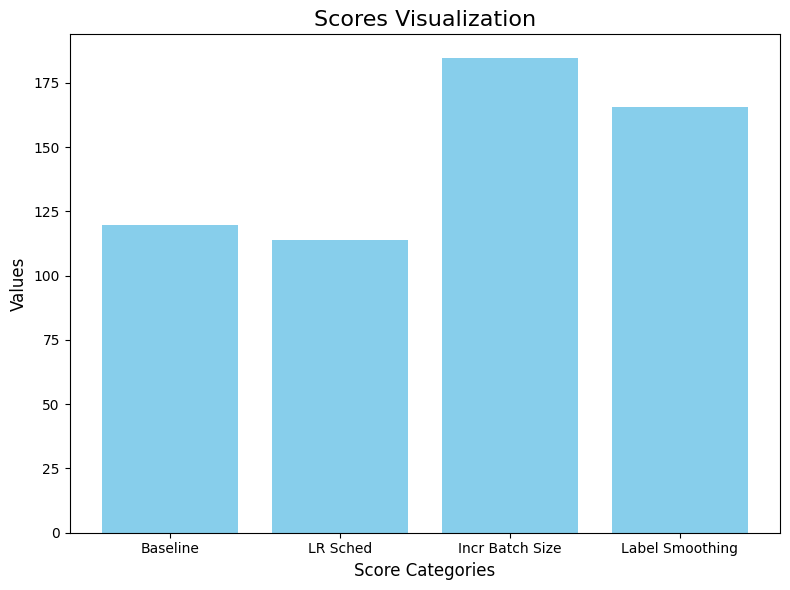

In [11]:
# Create the bar chart
plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color='skyblue')
plt.title('Scores , fontsize=16)
plt.xlabel('Score Categories', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.tight_layout()
plt.show()

The second model that incorporated the learning rate schedulers performed the best.  Increasing the batch size and adding label smoothing both caused the model to perform worse.

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

One aspect of this project that made it challenging to perform hyperparameter tuning is the amount of time it took to train a single model.  Training a single model would typically take 1 hour, depending on the computer that I was using.  If I had more time, I would like to perform the following tests.
1. Fine tune the number of epochs by saving the model after each epoch, then generating a batch of images from each of those models.  I could then look at the scores from each batch of images to select the best one.
2. Implement a CycleGAN.  The existing model has a generator (Photo -> Monet) and a discriminator (Monet discriminator). A CycleGAN would add a second generator (Monet -> Photo) and a second discriminator (Photo discriminator).  It would then use both generators during training to perhaps increase the accuracy.
3. Augment the dataset (both the photos and the Monet paintings) with transformations including random cropping, flipping, rotation, color jittering, scaling, and random noise addition.